In [51]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rc('axes.formatter', useoffset=False)

import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_regression

from sklearn import preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score

CV_verbose_param = 1

In [52]:
dataset = pd.read_csv('datasets/spotify_tracks_cleaned.csv')
dataset.head()

,artists,album_name,track_name,duration_ms,explicit,danceability,energy,key,loudness,mode,...,GENRE_spanish,GENRE_study,GENRE_swedish,GENRE_synth-pop,GENRE_tango,GENRE_techno,GENRE_trance,GENRE_trip-hop,GENRE_turkish,GENRE_world-music
0,Rill,Lolly,Lolly,160725,True,0.910,0.374,8,-9.844,0,...,0,0,0,0,0,0,0,0,0,0
1,Glee Cast,Glee Love Songs,It's All Coming Back To Me Now (Glee Cast Vers...,322933,False,0.269,0.516,0,-7.361,1,...,0,0,0,0,0,0,0,0,0,0
2,Paul Kalkbrenner;Pig&Dan,X,Böxig Leise - Pig & Dan Remix,515360,False,0.686,0.560,5,-13.264,0,...,0,0,0,0,0,0,0,0,0,0
3,Jordan Sandhu,Teeje Week,Teeje Week,190203,False,0.679,0.770,0,-3.537,1,...,0,0,0,0,0,0,0,0,0,0
4,Paul Kalkbrenner,Zeit,Tief,331240,False,0.519,0.431,6,-13.606,0,...,0,0,0,0,0,0,0,0,0,0


In [53]:
# dropping columns corresponding to categorical features

numerical_features = ['duration_ms','danceability','energy','loudness','speechiness',
          'acousticness','instrumentalness','liveness','valence','tempo','popularity']
columns_to_drop = list(dataset.columns)
for c in numerical_features:
    columns_to_drop.remove(c)
dataset.drop(columns=columns_to_drop, inplace=True)

In [54]:
X = dataset.drop(columns=['popularity'])    # features
y = dataset['popularity']                   # target variable

In [55]:
X['popularity_subsamples'] = y.map(lambda x: x if x % 2 == 0 else x+1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=X['popularity_subsamples'])

X_train.drop(columns='popularity_subsamples', inplace=True)
X_test.drop(columns='popularity_subsamples', inplace=True)

### Features selection

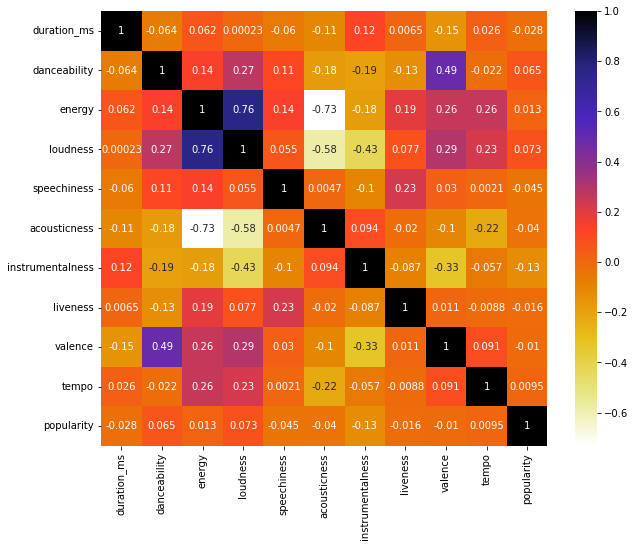

In [56]:
all_data = X_train.copy()
all_data['popularity'] = y_train
plt.figure(figsize=(10,8))
sns.heatmap(all_data.corr(), annot=True, cmap=plt.cm.CMRmap_r)
plt.show()

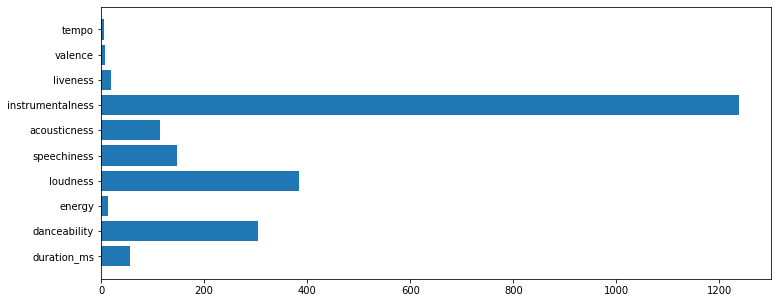

In [57]:
fs = SelectKBest(score_func=f_regression, k='all')
fs.fit(X_train, y_train)

plt.figure(figsize=(12,5))
plt.barh([X_train.columns[i] for i in range(len(fs.scores_))], fs.scores_)
plt.show()

The features with the worst predictive powers seems to be **tempo**, **valence**, **energy** and **liveness**

After some experiments, I decided to remove only **tempo** and **liveness**

In [58]:
worst_features = ['tempo', 'liveness']
X_train.drop(columns=worst_features, inplace=True)
X_test.drop(columns=worst_features, inplace=True)

### Features normalization

In [59]:
standard_scaler = preprocessing.StandardScaler().set_output(transform="pandas")

X_train = standard_scaler.fit_transform(X_train)
X_test = standard_scaler.transform(X_test)

## *Ridge Regression* on *Spotify Tracks Dataset* 

In [60]:
from ridge_regression import RR

### Hyper-parameters tuning

Fitting 5 folds for each of 25 candidates, totalling 125 fits


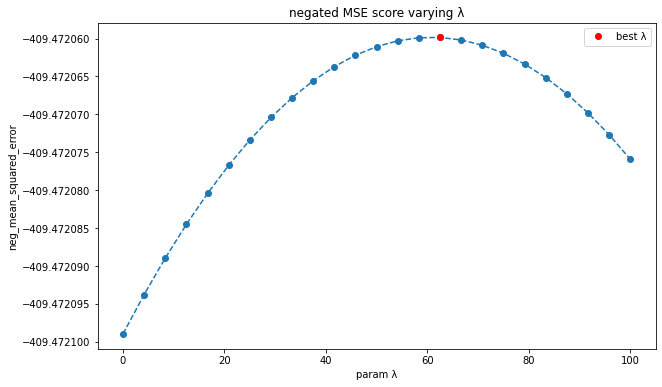

Best hyper-param is λ = 62.50000000000001 with a score of -409.47205985237053


In [61]:
λ_grid = np.linspace(0, 100, num=25)

learner = GridSearchCV(estimator=RR(), n_jobs=-1, param_grid={'λ': λ_grid}, scoring='neg_mean_squared_error', cv=5, verbose=CV_verbose_param)
learner.fit(X_train, y_train)

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(6)
ax.plot(learner.cv_results_['param_λ'].data, learner.cv_results_['mean_test_score'], linestyle='--', marker='o')
ax.plot(learner.best_params_['λ'], learner.best_score_, 'ro', label="best λ") 
ax.set(xlabel='param λ', ylabel='neg_mean_squared_error', title='negated MSE score varying λ')
plt.legend()
plt.show()

print(f'Best hyper-param is λ = {learner.best_params_["λ"]} with a score of {learner.best_score_}')

In [62]:
def print_performance(y_test, y_prediction):
    print(f'MSE : {mean_squared_error(y_test, y_prediction):.2f}')
    print(f' R2 : {r2_score(y_test, y_prediction):.2f}')

In [63]:
rr = learner.best_estimator_
rr.fit(X_train, y_train)
y_prediction = rr.predict(X_test)

print_performance(y_test, y_prediction)

MSE : 410.58
 R2 : 0.03


In [64]:
def residuals_analysis(y_test, y_prediction):
    
    residuals = y_test - y_prediction

    q1 = np.quantile(residuals, 0.25)
    q2 = np.quantile(residuals, 0.5)
    q3 = np.quantile(residuals, 0.75)
    iqr = q3 - q1

    print(f'q1          : {q1:.2f}')
    print(f'q2 (median) : {q2:.2f}')
    print(f'q3          : {q3:.2f}')
    print(f'IQR         : {iqr:.2f}')

    fig, ax = plt.subplots()
    fig.set_figwidth(8)
    fig.set_figheight(5)
    n, _, _  = ax.hist(residuals, density=True, bins=100)
    plt.errorbar(q2, max(n) + 0.002, xerr = [[q2-q1],[q3-q2]], fmt ='o', label="IQR") 
    plt.xlabel("residual (test - prediction)")
    plt.ylabel("relative frequency")
    plt.title("Density plot of the residuals")
    plt.legend()
    plt.show()

q1          : -13.72
q2 (median) : 0.18
q3          : 14.73
IQR         : 28.45


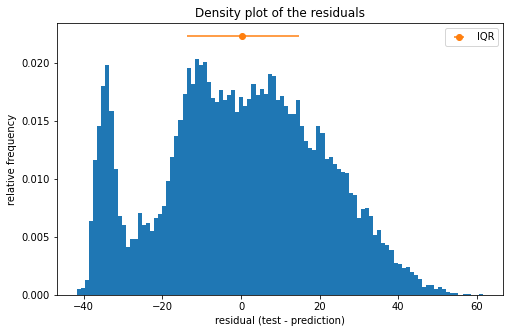

In [65]:
residuals_analysis(y_test, y_prediction)

Checking that my implementation performs exactly as the one in *sklearn*

In [66]:
from sklearn.linear_model import Ridge

debug = True

if debug:

    rr = Ridge(alpha=learner.best_params_['λ'])
    rr.fit(X_train, y_train)
    y_prediction = rr.predict(X_test)

    print_performance(y_test, y_prediction)

MSE : 410.58
 R2 : 0.03


## *Kernel Ridge Regression* on *Spotify Tracks Dataset*

Warning : some of the cells below will take 2-3 minutes to run

In [67]:
from kernel_ridge_regression import KRR

We run KRR just on samples of the dataset because, otherwise, it would get too computationally expensive 

In [68]:
train_sample_size = 5000

X_train_sample = X_train.sample(n=train_sample_size, random_state=1)
y_train_sample = pd.Series(data = [y_train[i] for i in X_train_sample.index], index = X_train_sample.index)

### Hyper-parameters tuning

In [69]:
all_experiments = True

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


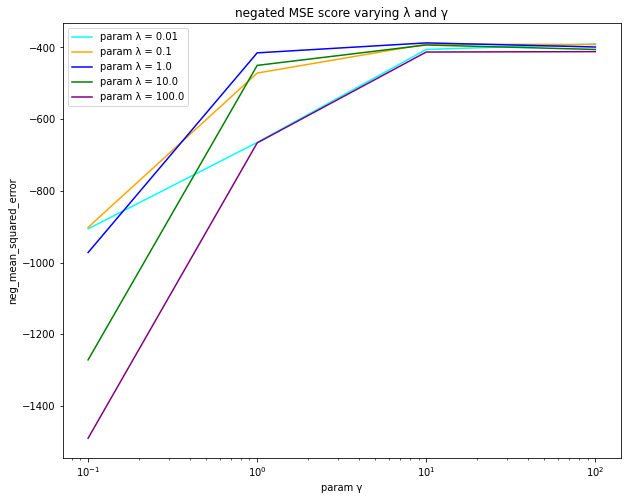

Best hyper-params are λ = 1.0 and γ = 10.0 with a score of -387.2650067834196


In [70]:
if all_experiments:
    
    λ_grid = 10. ** np.arange(-2, 3) 
    γ_grid = 10. ** np.arange(-1, 3) 

    learner = GridSearchCV(estimator=KRR(), n_jobs=-1, param_grid={'λ': λ_grid, 'γ': γ_grid}, scoring='neg_mean_squared_error', cv=5, verbose=CV_verbose_param)
    learner.fit(X_train_sample, y_train_sample)

    score = learner.cv_results_['mean_test_score']

    dict_λ = {}
    for v in set(learner.cv_results_['param_λ'].data):
        dict_λ[v] = (sorted(set(learner.cv_results_['param_γ'].data)), [])
    for i, p in enumerate(learner.cv_results_['params']):
        dict_λ[p['λ']][1].append(score[i])

    fig, ax = plt.subplots()
    fig.set_figwidth(10)
    fig.set_figheight(8)

    colors = ['purple', 'green', 'blue', 'orange', 'cyan']
    for k in sorted(dict_λ.keys()):
        ax.plot(dict_λ[k][0], dict_λ[k][1], label = f"param λ = {k}", linestyle='-', color = colors.pop())

    ax.set(xscale='log', xlabel='param γ', ylabel='neg_mean_squared_error', title='negated MSE score varying λ and γ')
    plt.legend()
    plt.show()

    print(f'Best hyper-params are λ = {learner.best_params_["λ"]} and γ = {learner.best_params_["γ"]} with a score of {learner.best_score_}')

In the following search we restrict the candidate values for the hyper-parameters 

Fitting 5 folds for each of 24 candidates, totalling 120 fits


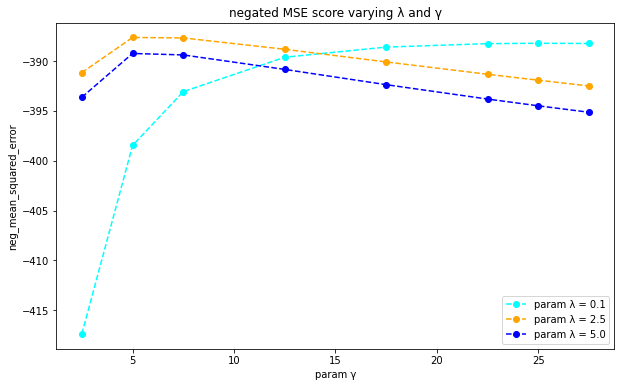

Best hyper-params are λ = 2.5 and γ = 5.0 with a score of -387.6316657581438


In [71]:
λ_grid = [0.1, 2.5, 5.0]
γ_grid = [2.5, 5.0, 7.5, 12.5, 17.5, 22.5, 25.0, 27.5]

learner = GridSearchCV(estimator=KRR(), n_jobs=-1, param_grid={'λ': λ_grid, 'γ': γ_grid}, scoring='neg_mean_squared_error', cv=5, verbose=CV_verbose_param)
learner.fit(X_train_sample, y_train_sample)

score = learner.cv_results_['mean_test_score']
dict_λ = {}
for v in set(learner.cv_results_['param_λ'].data):
    dict_λ[v] = (sorted(set(learner.cv_results_['param_γ'].data)), [])
for i, p in enumerate(learner.cv_results_['params']):
    dict_λ[p['λ']][1].append(score[i])

fig, ax = plt.subplots()
fig.set_figwidth(10)
fig.set_figheight(6)

colors = ['purple', 'green', 'blue', 'orange', 'cyan']
for k in sorted(dict_λ.keys()):
    ax.plot(dict_λ[k][0], dict_λ[k][1], label = f"param λ = {k}", linestyle='--', marker='o', color = colors.pop())

ax.set(xlabel='param γ', ylabel='neg_mean_squared_error', title='negated MSE score varying λ and γ')
plt.legend()
plt.show()

print(f'Best hyper-params are λ = {learner.best_params_["λ"]} and γ = {learner.best_params_["γ"]} with a score of {learner.best_score_}')

In [72]:
train_sample_size_BIG = 20000
test_sample_size_BIG = 4000

X_train_sample_BIG = X_train.sample(n=train_sample_size_BIG, random_state=1)
y_train_sample_BIG = pd.Series(data = [y_train[i] for i in X_train_sample_BIG.index], index = X_train_sample_BIG.index)

X_test_sample_BIG = X_test.sample(n=test_sample_size_BIG, random_state=1)
y_test_sample_BIG = pd.Series(data = [y_test[i] for i in X_test_sample_BIG.index], index = X_test_sample_BIG.index)

In [73]:
krr = learner.best_estimator_
krr.fit(X_train_sample_BIG, y_train_sample_BIG)
y_prediction = krr.predict(X_test_sample_BIG)

print_performance(y_test_sample_BIG, y_prediction)

MSE : 368.04
 R2 : 0.09


q1          : -12.05
q2 (median) : 0.32
q3          : 13.61
IQR         : 25.67


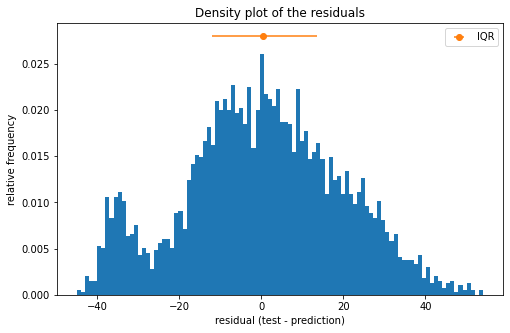

In [74]:
residuals_analysis(y_test_sample_BIG, y_prediction)

Checking that my implementation performs exactly as the one in *sklearn*

In [75]:
from sklearn.kernel_ridge import KernelRidge

debug = True

if debug:

    krr = KernelRidge(alpha=learner.best_params_["λ"], kernel="rbf", gamma=1/(learner.best_params_["γ"] * 2))
    krr.fit(X_train_sample_BIG, y_train_sample_BIG)
    y_prediction = krr.predict(X_test_sample_BIG)

    print_performance(y_test_sample_BIG, y_prediction)

MSE : 368.04
 R2 : 0.09
